# Wrench Feasible Workspace

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from scipy.interpolate import griddata


### Change Parameters

Only the parameters listed below are adjustable. Motor positions are first defined in a global coordinate system—whose origin is at the lower‑left corner of the robot system’s workspace—and then translated into a local coordinate system whose **origin coincides with the user’s hand**. This translation uses the `origin_offset_x`, `origin_offset_y`. Of the three motors, only the top motor’s `top_motor_x` may be varied; the other two remain fixed, since this maximally “spreads” the anchors and yields the best performance.

In [31]:
# Parameters
# Cable tension limits in N
T_min, T_max = 10, 40

# Motor configuration in mm
origin_offset_x = 1100
origin_offset_y = 700

In [32]:
# Motor anchor positions (origin in the left down corenr)
motor_global_pos = np.array([
    [90,210],
    [2920,230],
    [1230,2360]
])

motor_pos = motor_global_pos - np.array([origin_offset_x, origin_offset_y])

# Directions: e.g., 8 directions, spaced by 45 degrees
n_dirs = 8
angles = np.linspace(0, 2*np.pi, n_dirs, endpoint=False)
directions = np.array([[np.cos(a), np.sin(a)] for a in angles])

# Grid resolution (coarse)
NX = 50
NY = 50
x_vals = np.linspace(-2000, 2000, NX)
y_vals = np.linspace(-1000, 2000, NY)
X, Y = np.meshgrid(x_vals, y_vals)
performance_index = np.zeros_like(X)

In [33]:
def get_Jacobian(pos):
    """
    Returns a 2x3 matrix whose columns are the unit vectors
    from 'pos' to each motor anchor.
    """
    J = np.zeros((2, 3))
    for i in range(3):
        vec = motor_pos[i] - pos
        dist = np.linalg.norm(vec)
        if dist > 1e-9:
            J[:, i] = vec / dist
        else:
            # Degenerate case if exactly at a motor anchor
            J[:, i] = np.zeros(2)
    return J

def calc_performance_index(pos, dirs):
    """
    At 'pos', for each direction d in 'dirs':
      1) Solve an LP to maximize d^T * (J * T)
      2) If any direction is infeasible, return 0
    The final index is the MINIMUM over all directions
    of the maximum feasible force in that direction.
    """
    J = get_Jacobian(pos)
    # If J is degenerate (on top of a motor), it might be tricky:
    # We'll handle that as feasible but typically won't produce large force.
    
    min_force_across_dirs = np.inf
    
    for d in dirs:
        # We want to maximize d^T * (J * T).
        # That is the same as (d^T * J) * T, i.e. c^T T, where c = J^T d.
        # linprog does minimization, so we minimize -c^T T => c^T T = - ( -c^T T ).
        
        c = -(J.T @ d)  # negative because linprog is a minimizer
        bounds = [(T_min, T_max)] * J.shape[1]  # (3) for 3 cables
        
        res = linprog(c, bounds=bounds, method='highs')
        if not res.success:
            # If we can't exert force in direction d within tension bounds, index=0
            return 0.0
        # The objective is c^T T => res.fun is the minimized value => c^T T_min
        # But we used negative => the actual force_in_direction = -res.fun
        force_in_direction = -res.fun
        
        # We want the min across directions (worst-case direction)
        if force_in_direction < min_force_across_dirs:
            min_force_across_dirs = force_in_direction
    
    # If we never returned 0, it's feasible in all directions
    return min_force_across_dirs if min_force_across_dirs > 0 else 0

Computing performance index:   0%|          | 0/2500 [00:00<?, ?it/s]

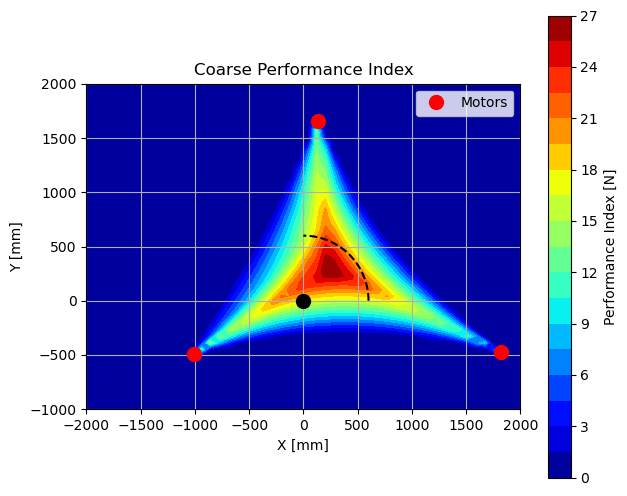

Motor positions (local): [[-1010  -490]
 [ 1820  -470]
 [  130  1660]]


In [ ]:
for idx in tqdm(range(NX * NY), desc="Computing performance index"):
    i = idx // NY
    j = idx % NY
    pos = np.array([X[i, j], Y[i, j]])
    performance_index[i, j] = calc_performance_index(pos, directions)

# Mask out infeasible or near-zero performance
# performance_masked = np.ma.masked_where(performance_index <= 1e-3, performance_index)

performance_index_plot = performance_index.copy()
performance_index_plot[performance_index_plot < 1e-3] = 0

# =========================================
#  Plot the Coarse Contour
# =========================================
fig, ax = plt.subplots(figsize=(7, 6))
cs = ax.contourf(X, Y, performance_index, levels=20, cmap='jet')
cbar = fig.colorbar(cs, ax=ax, label='Performance Index [N]')

# Plot motor positions
ax.plot(motor_pos[:, 0], motor_pos[:, 1], 'ro', markersize=10, label='Motors')

ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_title('Coarse Performance Index')
ax.set_aspect('equal')
ax.grid(True)
ax.legend()

# Plot Circle trajectory
circle_radius = 600
circle_theta = np.linspace(0, 1/2 * np.pi, 100)
circle_x = circle_radius * np.cos(circle_theta) 
circle_y = circle_radius * np.sin(circle_theta)
ax.plot(circle_x, circle_y, 'k--', label='Circle Trajectory', alpha=1)
# Plot the origin
ax.plot(0, 0, 'ko', markersize=10, label='Origin')

plt.show()

In [41]:
print("Motor positions (local):", motor_pos)
row_norms = np.linalg.norm(motor_pos, axis=1)
print("Cable Length :",row_norms)

Motor positions (local): [[-1010  -490]
 [ 1820  -470]
 [  130  1660]]
Cable Length : [1122.58629958 1879.70742404 1665.08258053]
